In [1]:
import numpy as np
import cv2

def perspect_transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img_size[0]/2 - dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - bottom_offset],
                      [img_size[0]/2 + dst_size, img_size[1] - 2*dst_size - bottom_offset], 
                      [img_size[0]/2 - dst_size, img_size[1] - 2*dst_size - bottom_offset],
                      ])
       
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)# keep same size as input image
    return warped

def color_thresh(img, rgb_thresh=(170, 170, 170)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
    
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel


Xpos = [ 63.21826943] Ypos = [ 90.80666106] Yaw = [ 35.63683555]


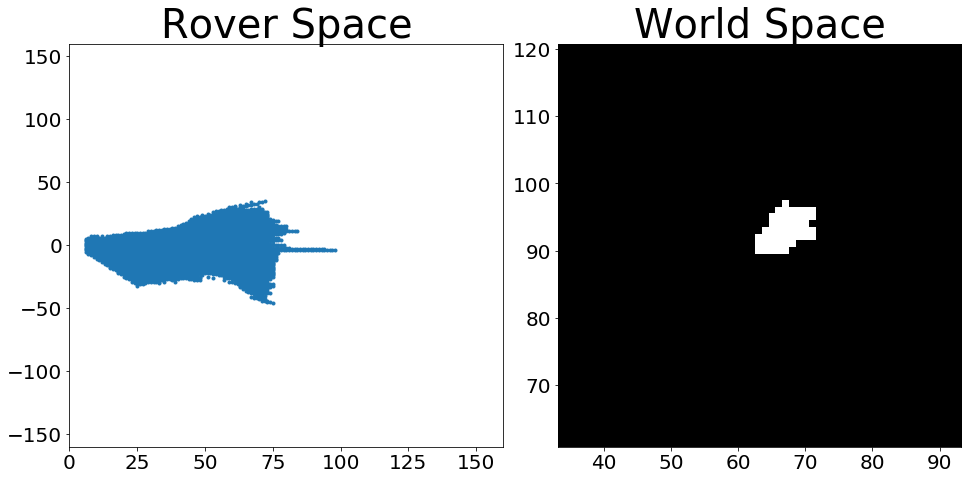

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Read in the sample image
image = mpimg.imread('sample.jpg')

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

def pix_to_world(xpix, ypix, xpos, ypos, yaw, worldsize, scale):
    
    
    # TODO:
    # Apply a rotation 
        # NOTE: don't forget to convert to radians
    yaw_rad = yaw * np.pi / 180
    x_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    y_rotated = xpix * np.sin(yaw_rad) + ypix * np.sin(yaw_rad)
    # Apply a translation
        # NOTE: don't forget to scale between rover and world space
    
    # Perform translation and convert to integer since pixel values can't be float
    x_world = np.int_(xpos + (x_rotated / scale))
    y_world = np.int_(ypos + (y_rotated / scale))
    # Convert to integer and truncate to allowable world space values
    x_pix_world = np.clip(x_world, 0, worldsize - 1)
    y_pix_world = np.clip(y_world, 0, worldsize - 1)
    return x_pix_world, y_pix_world
    

# No need to modify code below here
# Perform warping and color thresholding
warped = perspect_transform(image)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_ylim(rover_ypos-30, rover_ypos+30)
ax2.set_xlim(rover_xpos-30, rover_xpos+30)

plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)

In [7]:
# Define a function to convert from cartesian to polar coordinates
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

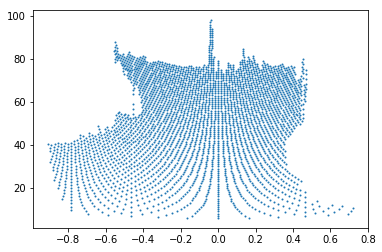

In [9]:
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
%matplotlib inline
import numpy as np

warped = perspect_transform(image)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
xpix, ypix = rover_coords(colorsel)
distances, angles = to_polar_coords(xpix, ypix)
plt.plot(angles, distances, '.', markersize=2)

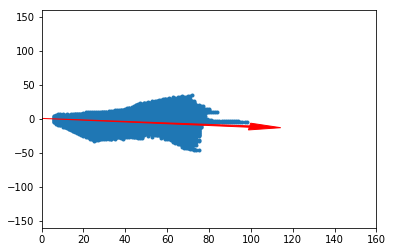

In [10]:
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)

# Compute the average angle
mean_angle = np.mean(angles)
# Define an arrow that's 100 pixels long
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_angle)
y_arrow = arrow_length * np.sin(mean_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, 
                   head_width=10, width=2)

In [12]:
avg_angle_degrees = mean_angle * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)
print('steering angle to send:', steering)

steering angle to send: -6.32291704086
